In [1]:
import pandas as pd
import numpy as np


red = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep=';')
white = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", sep=';')

# Add wine_type
red['wine_type'] = 0  # red = 0
white['wine_type'] = 1  # white = 1

# Combine datasets
wine_df = pd.concat([red, white], axis=0, ignore_index=True)
wine_df.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


In [2]:
import numpy as np

# Create a copy to avoid modifying original data
wine_missing = wine_df.copy()

# 1. MCAR: Randomly remove 5% of citric_acid values
np.random.seed(54)
mcar_indices = wine_missing.sample(frac=0.07).index
wine_missing.loc[mcar_indices, 'citric acid'] = np.nan

# 2. MAR: Remove 3% of sulphates where quality < 5
mar_condition = wine_missing[wine_missing['quality'] < 5]
mar_indices = mar_condition.sample(frac=0.03, random_state=42).index
wine_missing.loc[mar_indices, 'sulphates'] = np.nan

# Check missing counts

print("🔍 Missing values:\n", wine_missing[['citric acid', 'sulphates']].isnull().sum())

🔍 Missing values:
 citric acid    455
sulphates        7
dtype: int64


In [3]:
from sklearn.impute import SimpleImputer

mean_imputer = SimpleImputer(strategy='mean')
wine_mean = wine_missing.copy()
wine_mean[['citric acid', 'sulphates']] = mean_imputer.fit_transform(wine_mean[['citric acid', 'sulphates']])


In [4]:
median_imputer = SimpleImputer(strategy='median')
wine_median = wine_missing.copy()
wine_median[['citric acid', 'sulphates']] = median_imputer.fit_transform(wine_median[['citric acid', 'sulphates']])
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=5)
wine_knn = wine_missing.copy()
wine_knn[['citric acid', 'sulphates']] = knn_imputer.fit_transform(wine_knn[['citric acid', 'sulphates']])


In [5]:
print("📌 Comparison of Imputation Strategies:")
print("\nMean Strategy:")
print(wine_mean[['citric acid', 'sulphates']].describe())

print("\nMedian Strategy:")
print(wine_median[['citric acid', 'sulphates']].describe())

print("\nKNN Strategy:")
print(wine_knn[['citric acid', 'sulphates']].describe())


📌 Comparison of Imputation Strategies:

Mean Strategy:
       citric acid    sulphates
count  6497.000000  6497.000000
mean      0.317696     0.531277
std       0.139568     0.148785
min       0.000000     0.220000
25%       0.250000     0.430000
50%       0.317696     0.510000
75%       0.380000     0.600000
max       1.660000     2.000000

Median Strategy:
       citric acid    sulphates
count  6497.000000  6497.000000
mean      0.317157     0.531254
std       0.139582     0.148787
min       0.000000     0.220000
25%       0.250000     0.430000
50%       0.310000     0.510000
75%       0.380000     0.600000
max       1.660000     2.000000

KNN Strategy:
       citric acid    sulphates
count  6497.000000  6497.000000
mean      0.318532     0.531298
std       0.140780     0.148806
min       0.000000     0.220000
25%       0.250000     0.430000
50%       0.310000     0.510000
75%       0.390000     0.600000
max       1.660000     2.000000


In [6]:
wine_df.mean()

fixed acidity             7.215307
volatile acidity          0.339666
citric acid               0.318633
residual sugar            5.443235
chlorides                 0.056034
free sulfur dioxide      30.525319
total sulfur dioxide    115.744574
density                   0.994697
pH                        3.218501
sulphates                 0.531268
alcohol                  10.491801
quality                   5.818378
wine_type                 0.753886
dtype: float64

In [7]:
def add_engineered_features(df):
    df['acid_ratio'] = df['fixed acidity'] / (df['volatile acidity'] + 1e-5)  # Avoid divide by zero
    df['sulfur_ratio'] = df['free sulfur dioxide'] / (df['total sulfur dioxide'] + 1e-5)
    df['alcohol_sugar_interaction'] = df['alcohol'] * df['residual sugar']
    return df

# Apply to the KNN-imputed dataset (recommended)
wine_fe = add_engineered_features(wine_df.copy())

# Quick check
wine_fe[['acid_ratio', 'sulfur_ratio', 'alcohol_sugar_interaction']].describe()

,acid_ratio,sulfur_ratio,alcohol_sugar_interaction
count,6497.000000,6497.000000,6497.000000
mean,25.337083,0.286768,55.070088
std,10.733303,0.124645,45.643541
min,4.807646,0.022727,6.360000
25%,17.691854,0.202073,19.040000
50%,23.999040,0.269767,33.020000
75%,31.051814,0.348837,82.140000
max,89.988751,0.857143,769.860000


In [8]:
# Drop target column for scaling
features = wine_fe.drop('quality', axis=1).columns

X = wine_fe[features]
y = wine_fe['quality']

In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Initialize scalers
standard = StandardScaler()
minmax = MinMaxScaler()
robust = RobustScaler()

# Apply scalers
X_standard = standard.fit_transform(X)
X_minmax = minmax.fit_transform(X)
X_robust = robust.fit_transform(X)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def evaluate_scaler(X_scaled, y, scaler_name):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=68)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{scaler_name} Accuracy: {acc:.4f}")
    return acc

acc_std = evaluate_scaler(X_standard, y, "StandardScaler")
acc_min = evaluate_scaler(X_minmax, y, "MinMaxScaler")
acc_rob = evaluate_scaler(X_robust, y, "RobustScaler")


StandardScaler Accuracy: 0.5436
MinMaxScaler Accuracy: 0.5436
RobustScaler Accuracy: 0.5323


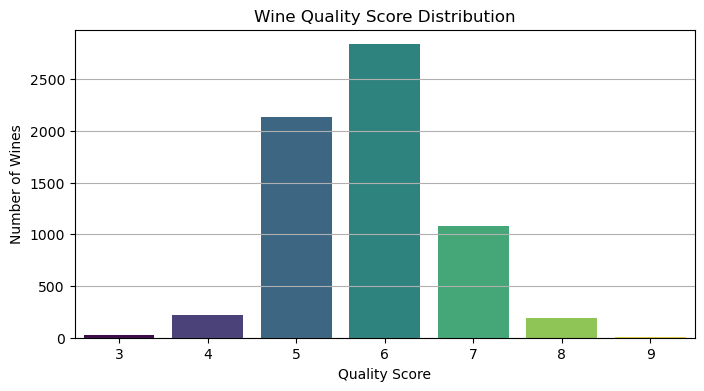

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count of quality scores
plt.figure(figsize=(8, 4))
sns.countplot(x='quality', hue='quality', data=wine_fe, palette='viridis', legend=False)
plt.title("Wine Quality Score Distribution")
plt.xlabel("Quality Score")
plt.ylabel("Number of Wines")
plt.grid(axis='y')
plt.show()

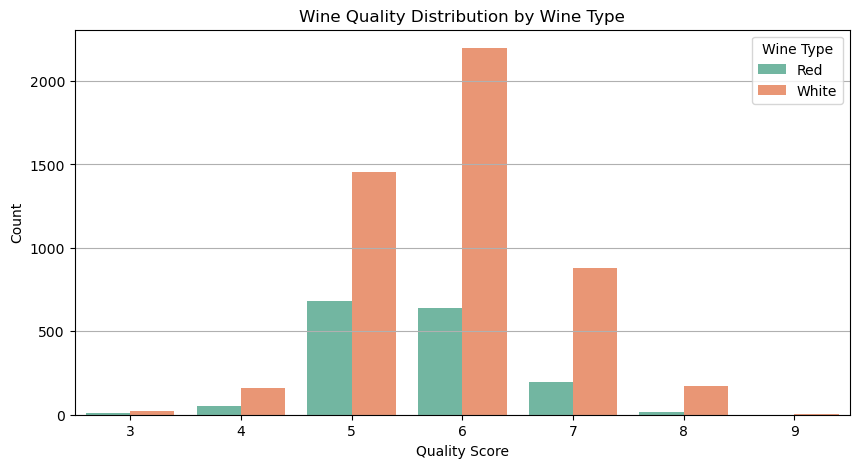

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure wine_type is categorical for clear labeling
wine_fe['wine_type'] = wine_fe['wine_type'].map({0: 'Red', 1: 'White'})

# Plot
plt.figure(figsize=(10, 5))
sns.countplot(x='quality', hue='wine_type', data=wine_fe, palette='Set2')
plt.title("Wine Quality Distribution by Wine Type")
plt.xlabel("Quality Score")
plt.ylabel("Count")
plt.legend(title="Wine Type")  # Let Seaborn handle labels
plt.grid(axis='y')
plt.show()


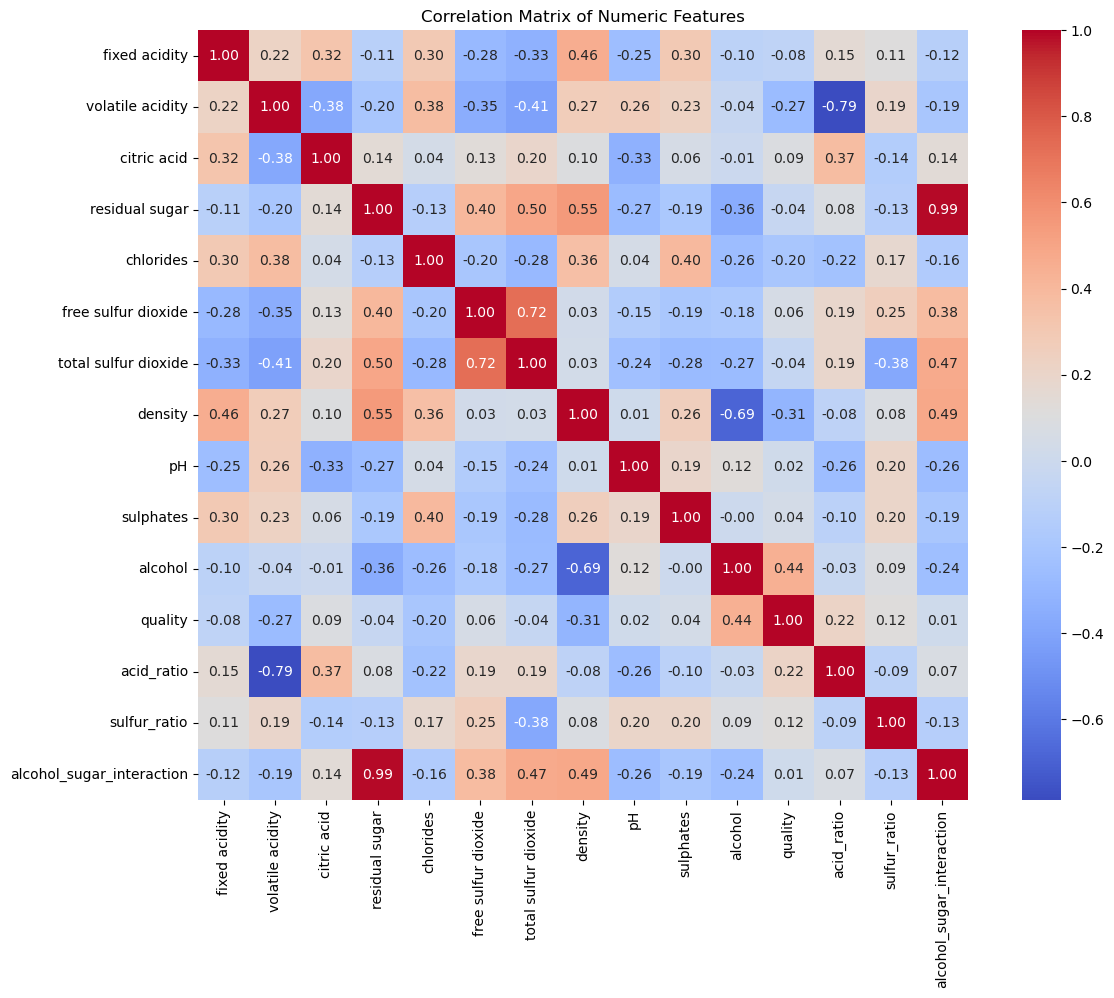

In [13]:
#Select only numeric columns
numeric_df = wine_fe.select_dtypes(include='number')

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix of Numeric Features")
plt.show()

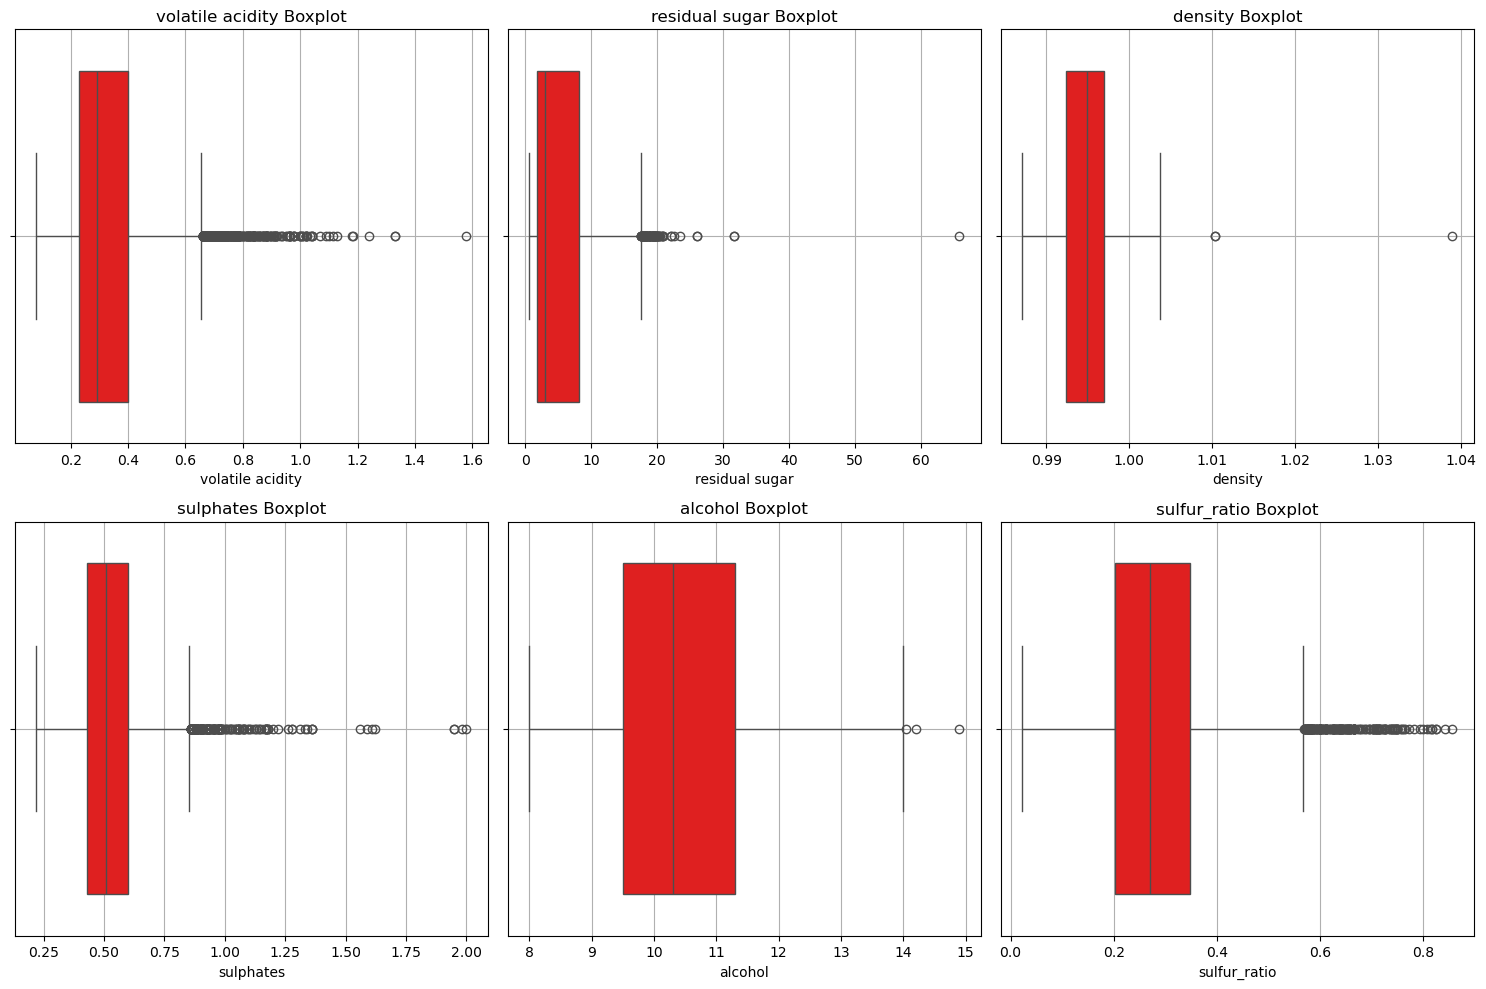

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select important features
important_features = [
    'volatile acidity', 'residual sugar', 'density',
    'sulphates', 'alcohol', 'sulfur_ratio'
]

plt.figure(figsize=(15, 10))

for i, col in enumerate(important_features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=wine_fe[col], color='red')
    plt.title(f'{col} Boxplot')
    plt.grid(True)

plt.tight_layout()
plt.show()


In [15]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Step 0: Drop classes with fewer than 10 total samples to guarantee safety in 70-15-15 split
min_required_samples = 10  # Because 10 → 7 (train), 1.5 (val), 1.5 (test)
value_counts = wine_knn['quality'].value_counts()
valid_classes = value_counts[value_counts >= min_required_samples].index

wine_safe = wine_knn[wine_knn['quality'].isin(valid_classes)].copy()

# Step 1: Define X and y
X = wine_safe.drop('quality', axis=1)
y = wine_safe['quality']

# Step 2: Train (70%) vs Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

# Step 3: Validation (15%) and Test (15%) from Temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

# Step 4: Print shapes
print("✅ FINAL DATA SPLIT:")
print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)

# Optional: Verify class distribution
print("\n🎯 Class distribution in Train:\n", y_train.value_counts(normalize=True).sort_index())
print("\n🎯 Class distribution in Validation:\n", y_val.value_counts(normalize=True).sort_index())
print("\n🎯 Class distribution in Test:\n", y_test.value_counts(normalize=True).sort_index())


✅ FINAL DATA SPLIT:
Train: (4544, 12)
Validation: (974, 12)
Test: (974, 12)

🎯 Class distribution in Train:
 quality
3    0.004621
4    0.033231
5    0.329445
6    0.436840
7    0.166153
8    0.029710
Name: proportion, dtype: float64

🎯 Class distribution in Validation:
 quality
3    0.004107
4    0.033881
5    0.328542
6    0.437372
7    0.166324
8    0.029774
Name: proportion, dtype: float64

🎯 Class distribution in Test:
 quality
3    0.005133
4    0.032854
5    0.329569
6    0.436345
7    0.166324
8    0.029774
Name: proportion, dtype: float64


In [34]:

# Step 1: Import libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_absolute_error, classification_report, root_mean_squared_error
)

# Step 2: Create KNN model with k=5
knn = KNeighborsClassifier(n_neighbors=5)

# Step 3: Fit model to training data
knn.fit(X_train, y_train)

# Step 4: Predict on test data
y_pred = knn.predict(X_test)

# Step 5: Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

# Step 6: Print results
print("✅ KNN Model Evaluation Results:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"MAE      : {mae:.4f}")
print(f"RMSE     : {rmse:.4f}")

# Step 7: Optional - Detailed report by class
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))




✅ KNN Model Evaluation Results:
Accuracy : 0.4754
Precision: 0.4603
Recall   : 0.4754
F1-Score : 0.4608
MAE      : 0.6242
RMSE     : 0.9231

📋 Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         5
           4       0.15      0.06      0.09        32
           5       0.48      0.58      0.52       321
           6       0.49      0.54      0.51       425
           7       0.44      0.28      0.34       162
           8       0.30      0.10      0.15        29

    accuracy                           0.48       974
   macro avg       0.31      0.26      0.27       974
weighted avg       0.46      0.48      0.46       974



In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ---------- 1. Quality-Weighted Accuracy (Custom Metric) ----------
def quality_weighted_accuracy(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    correct = np.abs(y_true - y_pred) <= 1  # Allow ±1 difference
    return np.mean(correct)

qwa = quality_weighted_accuracy(y_test, y_pred)
print(f"✅ Quality-Weighted Accuracy (±1 allowed): {qwa:.4f}")

✅ Quality-Weighted Accuracy (±1 allowed): 0.9138


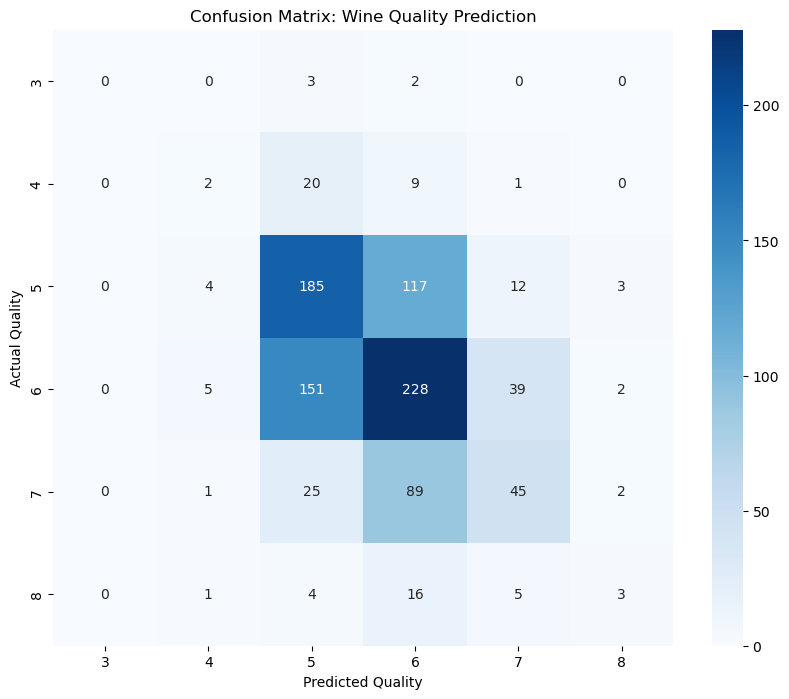

In [37]:
# ---------- 2. Confusion Matrix ----------
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=sorted(y_test.unique()))

# Plot it
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y_test.unique()),
            yticklabels=sorted(y_test.unique()))
plt.xlabel("Predicted Quality")
plt.ylabel("Actual Quality")
plt.title("Confusion Matrix: Wine Quality Prediction")
plt.show()


In [38]:
# ---------- 3. Business-Relevant Cost Function ----------
def wine_cost_function(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    cost = np.abs(y_true - y_pred)  # Absolute error
    return np.mean(cost)

business_cost = wine_cost_function(y_test, y_pred)
print(f"💰 Business Cost (Avg. Absolute Error): {business_cost:.2f}")


💰 Business Cost (Avg. Absolute Error): 0.62


In [39]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import numpy as np


In [40]:
def evaluate_knn_k_values(X, y, cv_strategy, max_k=50):
    k_range = range(1, max_k + 1)
    cv_scores = []

    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=cv_strategy, scoring='accuracy')
        cv_scores.append(scores.mean())

    return k_range, cv_scores

In [41]:
# Choose 5-fold CV (you can increase to 10 if needed)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use your full training set (X_train, y_train)
k_values, scores_kf = evaluate_knn_k_values(X_train, y_train, kf)
_, scores_skf = evaluate_knn_k_values(X_train, y_train, skf)

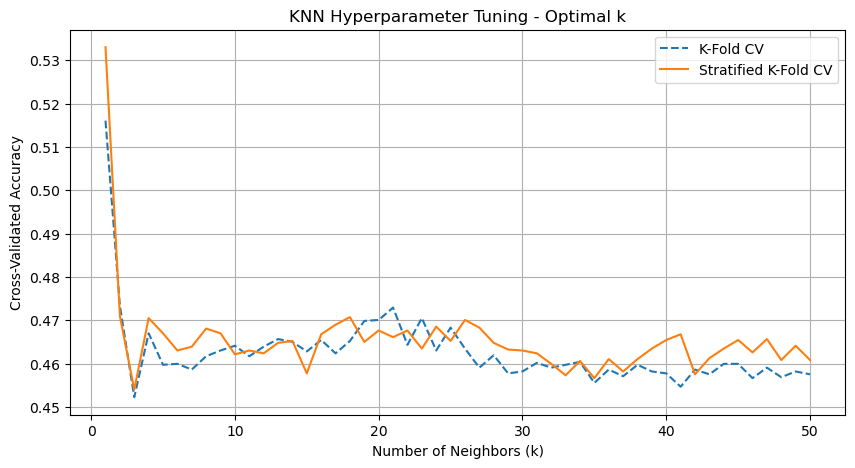

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(k_values, scores_kf, label='K-Fold CV', linestyle='--')
plt.plot(k_values, scores_skf, label='Stratified K-Fold CV', linestyle='-')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('KNN Hyperparameter Tuning - Optimal k')
plt.legend()
plt.grid(True)
plt.show()


In [43]:
best_k_kf = k_values[np.argmax(scores_kf)]
best_k_skf = k_values[np.argmax(scores_skf)]

print(f"🏆 Best k using K-Fold CV: {best_k_kf} with accuracy = {max(scores_kf):.4f}")
print(f"🏆 Best k using Stratified K-Fold CV: {best_k_skf} with accuracy = {max(scores_skf):.4f}")


🏆 Best k using K-Fold CV: 1 with accuracy = 0.5161
🏆 Best k using Stratified K-Fold CV: 1 with accuracy = 0.5330


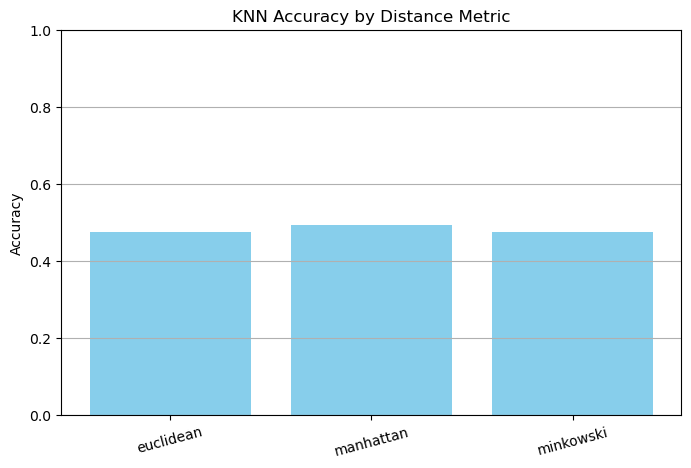

In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Define different distance metrics to test
metrics = ['euclidean', 'manhattan', 'minkowski']
results = {}

# Train and test KNN using each metric
for metric in metrics:
    knn = KNeighborsClassifier(n_neighbors=5, metric=metric)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[metric] = acc

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(results.keys(), results.values(), color='skyblue')
plt.ylabel("Accuracy")
plt.title("KNN Accuracy by Distance Metric")
plt.xticks(rotation=15)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

In [52]:
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier, LocalOutlierFactor
from sklearn.metrics import accuracy_score
import numpy as np

# Store results
advanced_results = {}

# 1️⃣ Weighted KNN (distance-based)
knn_weighted = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_weighted.fit(X_train, y_train)
y_pred_weighted = knn_weighted.predict(X_test)
advanced_results['Weighted KNN'] = accuracy_score(y_test, y_pred_weighted)

# 2️⃣ Radius-Based Neighbors
radius_knn = RadiusNeighborsClassifier(radius=5.0, weights='distance', outlier_label=0)
radius_knn.fit(X_train, y_train)
y_pred_radius = radius_knn.predict(X_test)

# Exclude outliers (-1) from accuracy calc
mask = y_pred_radius != 10
if np.any(mask):
    acc_radius = accuracy_score(y_test[mask], y_pred_radius[mask])
    advanced_results['Radius KNN'] = acc_radius
else:
    advanced_results['Radius KNN'] = 0.0  # fallback if all are outliers

# 3️⃣ Local Outlier Factor (Optional Step for Insight)
lof = LocalOutlierFactor(n_neighbors=20)
outlier_labels = lof.fit_predict(X_train)
num_outliers = np.sum(outlier_labels == 10)

print("📊 Advanced KNN Accuracy Results:")
for method, acc in advanced_results.items():
    print(f"{method}: {acc:.4f}")

print(f"\n🔎 Detected {num_outliers} outliers in training data using LOF.")


📊 Advanced KNN Accuracy Results:
Weighted KNN: 0.6867
Radius KNN: 0.4800

🔎 Detected 0 outliers in training data using LOF.


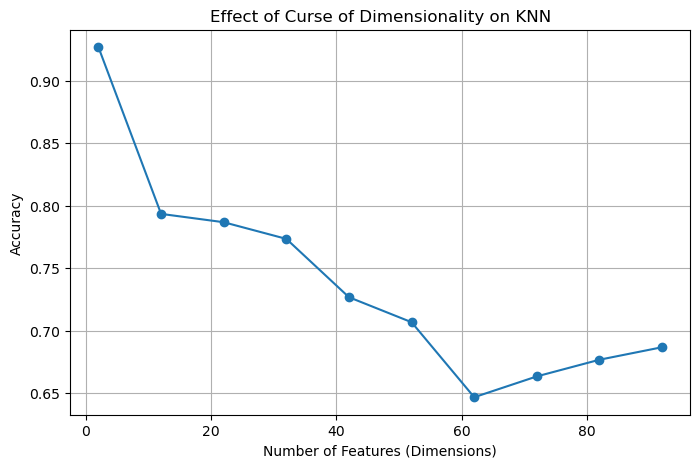

In [53]:
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

dims = list(range(2, 101, 10))  # Increase dimensions: 2, 12, ..., 100
accuracies = []

for d in dims:
    X, y = make_classification(n_samples=1000, n_features=d, n_informative=2, n_redundant=0, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    acc = knn.score(X_test, y_test)
    accuracies.append(acc)

plt.figure(figsize=(8, 5))
plt.plot(dims, accuracies, marker='o')
plt.xlabel("Number of Features (Dimensions)")
plt.ylabel("Accuracy")
plt.title("Effect of Curse of Dimensionality on KNN")
plt.grid(True)
plt.show()


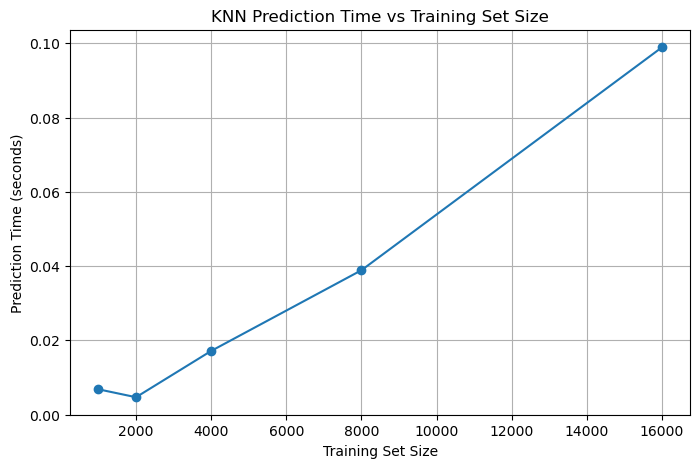

In [54]:
import time
sizes = [1000, 2000, 4000, 8000, 16000]
times = []

for size in sizes:
    X, y = make_classification(n_samples=size, n_features=20, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)

    start = time.time()
    knn.predict(X_test)
    end = time.time()
    
    times.append(end - start)

plt.figure(figsize=(8, 5))
plt.plot(sizes, times, marker='o')
plt.xlabel("Training Set Size")
plt.ylabel("Prediction Time (seconds)")
plt.title("KNN Prediction Time vs Training Set Size")
plt.grid(True)
plt.show()


In [56]:
import numpy as np
X, y = make_classification(n_samples=5000, n_features=20, random_state=42)
memory_usage_MB = X.nbytes / (1024 ** 2)
print(f"Estimated Memory Usage for 5000 samples and 20 features: {memory_usage_MB:.2f} MB")

Estimated Memory Usage for 5000 samples and 20 features: 0.76 MB


In [57]:
from sklearn.metrics import classification_report

# Create imbalanced dataset
X, y = make_classification(n_samples=2000, n_features=10, weights=[0.95, 0.05], random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       568
           1       0.79      0.47      0.59        32

    accuracy                           0.96       600
   macro avg       0.88      0.73      0.78       600
weighted avg       0.96      0.96      0.96       600



In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import time

In [59]:
# Assuming imputation already done, e.g., using wine_mean
df = wine_df.copy()

X = df.drop(columns=['quality'])
y = df['quality']

# Optional: You can treat this as classification or regression; we’ll treat it as classification
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)